In [1]:
import os
import pandas as pd
from load_ulg import load_ulg, timeframe
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, HuberRegressor
# model_name = "x500"
# model_name = "race6"
model_name = "fs"
if model_name == 'x500':
    from geometry import x500 as model
elif model_name == "race6":
    from geometry import race6 as model
elif model_name == "fs":
    from geometry import fs as model
else:
    raise ValueError("Unknown model name")

from process import throttle_thrust, find_tau, fit_tau, plot_thrust_curve, torque_angular_acceleration, fit_inertia, plot_torque_angular_acceleration_curve
import numpy as np

In [2]:
if model_name in ["x500", "fs"]:
    output_topic = "actuator_motors_mux" # use "actuator_controls" for the unmodified PX4
else:
    output_topic = "actuator_motors" # use "actuator_controls" for the unmodified PX4

### Loading the logfile into a Pandas dataframe

In [3]:
if model_name == 'x500':
    ulog_files = [
        # "logs/test.ulg",
        # "logs/test2.ulg"
        "logs/2023-12-27-x500/log_36_2023-12-27-14-21-32.ulg",
        "logs/2023-12-27-x500/log_37_2023-12-27-14-24-24.ulg"
    ]
elif model_name == "race6":
    ulog_files = [
        "logs/2023-12-13-nishanth-sysid/log_45_2023-12-13-21-07-46-up-and-down.ulg",
        "logs/2023-12-14-yang-crash/log_60_2023-12-14-20-26-16.ulg",
        "logs/2023-12-13-nishanth-sysid/log_46_2023-12-13-21-08-08-left-and-right.ulg"
    ]
elif model_name == "fs":
    ulog_files = [
        "logs/2024-01-08-pavel-fs/log_63_2024-1-8-16-37-54.ulg",
        "logs/2024-01-08-pavel-fs/log_64_2024-1-8-16-39-44.ulg",
        "logs/2024-01-08-pavel-fs/log_65_2024-1-8-16-40-52.ulg",
        "logs/2024-01-08-pavel-fs/log_66_2024-1-8-16-42-48.ulg",
        "logs/2024-01-12-pavel policy test/log_76_2024-1-12-17-25-30.ulg",
        "logs/2024-01-12-pavel policy test/log_77_2024-1-12-17-27-50.ulg"
    ]

dfs = [load_ulg(file) for file in ulog_files]

### Exploring the datapoints in the dataframe

In [4]:
grep = "attitude"
[col for col in dfs[0].columns if grep in col]

['actuator_motors_mux_timestamp',
 'actuator_motors_mux_control[0]',
 'actuator_motors_mux_control[1]',
 'actuator_motors_mux_control[2]',
 'actuator_motors_mux_control[3]',
 'actuator_motors_mux_control[4]',
 'actuator_motors_mux_control[5]',
 'actuator_motors_mux_control[6]',
 'actuator_motors_mux_control[7]',
 'actuator_motors_mux_control[8]',
 'actuator_motors_mux_control[9]',
 'actuator_motors_mux_control[10]',
 'actuator_motors_mux_control[11]',
 'actuator_motors_mux_reversible_flags']

### Looking at the outputs to find the relevant timeframe

File 0: logs/2024-01-08-pavel-fs/log_63_2024-1-8-16-37-54.ulg


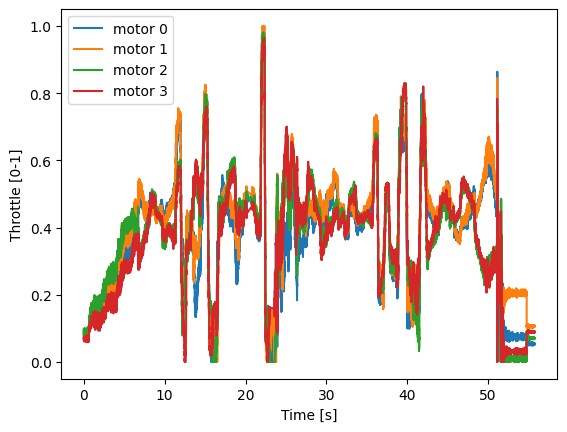

File 1: logs/2024-01-08-pavel-fs/log_64_2024-1-8-16-39-44.ulg


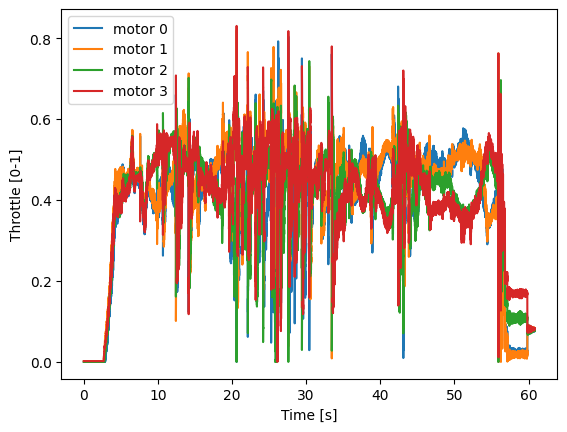

File 2: logs/2024-01-08-pavel-fs/log_65_2024-1-8-16-40-52.ulg


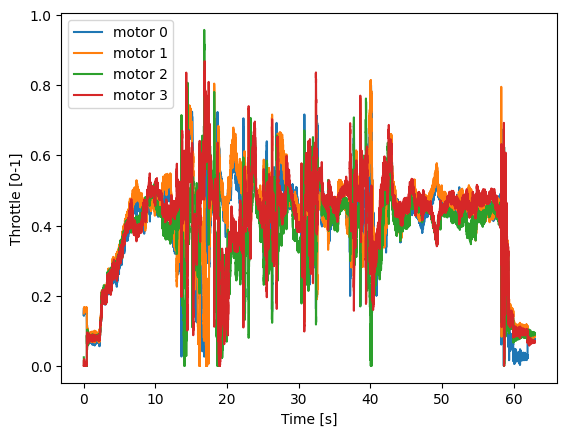

File 3: logs/2024-01-08-pavel-fs/log_66_2024-1-8-16-42-48.ulg


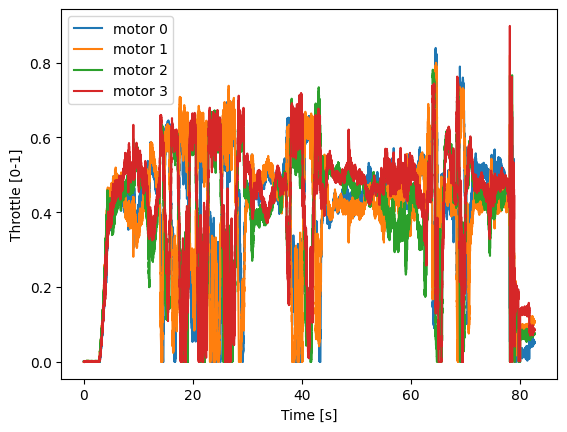

File 4: logs/2024-01-12-pavel policy test/log_76_2024-1-12-17-25-30.ulg


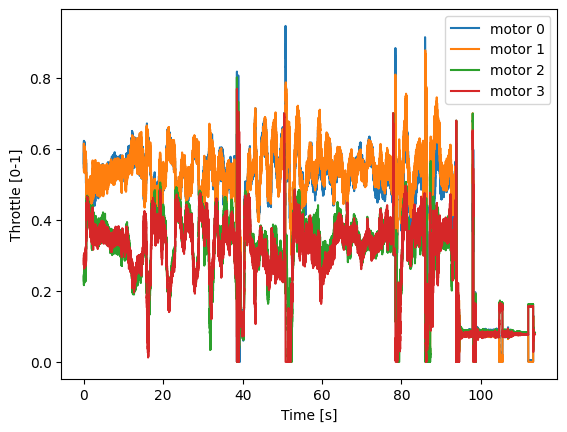

File 5: logs/2024-01-12-pavel policy test/log_77_2024-1-12-17-27-50.ulg


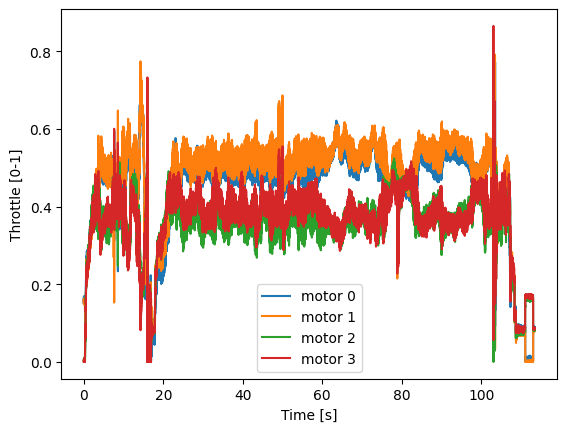

In [5]:
plot_activation = False
for i_file, (file, df) in enumerate(zip(ulog_files, dfs)):
    print(f"File {i_file}: {file}")
    plt.figure()
    # plt.title(f"file {i_file}: {file}")
    for i_motor in range(4):
        s = df[f"{output_topic}_control[{i_motor}]"].dropna()
        plt.plot(s.index, s, label=f"motor {i_motor}")
    plt.xlabel("Time [s]")
    plt.ylabel("Throttle [0-1]")
    plt.legend()
    plt.savefig(f"figures/throttle_file_{i_file}_{model_name}.pdf")
    if "rl_tools_multiplexer_status_active" in df.columns and plot_activation:
        s = df["rl_tools_multiplexer_status_active"].dropna()
        plt.plot(s.index, s, label="active")
    plt.show()

In [6]:
if model_name == "x500":
    timeframes = [
        # (30, 50),
        # (15, 50),
        (30, 50),
        (10, 40),
    ]
elif model_name == "race6":
    timeframes = [
        (4, 10),
        (7, 11),
        (2.5, 12.5),
    ]
elif model_name == "fs":
    timeframes = [
        (10, 45),
        (10, 45),
        (10, 45),
        (10, 75),
        (20, 90),
        (20, 100),
    ]
else:
    raise ValueError("Unknown model name")
dfs = [timeframe(df, time_start, time_end) for df, (time_start, time_end) in zip(dfs, timeframes)]

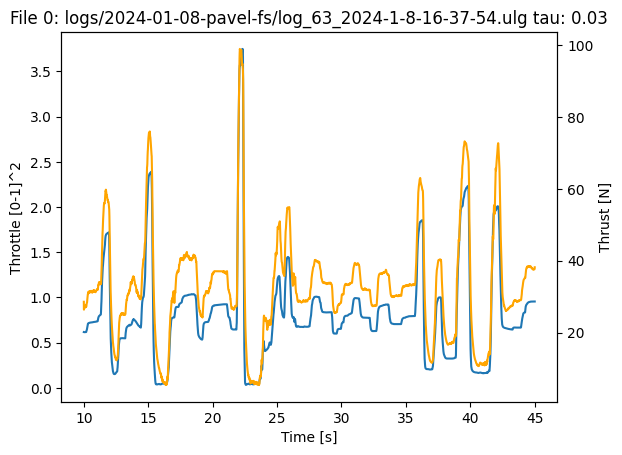

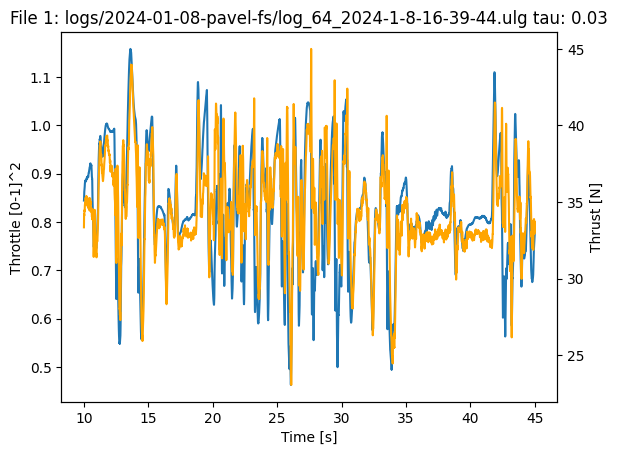

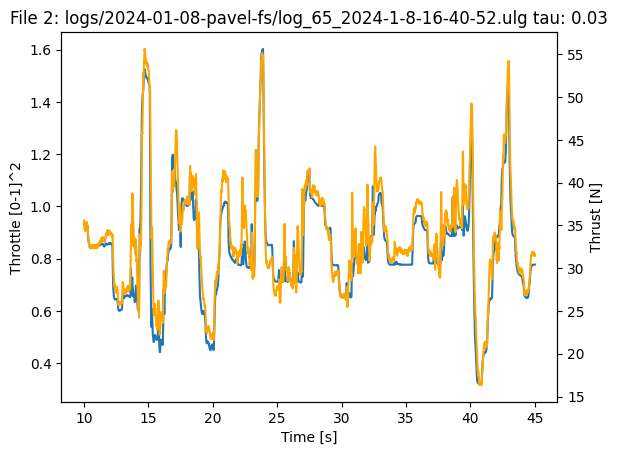

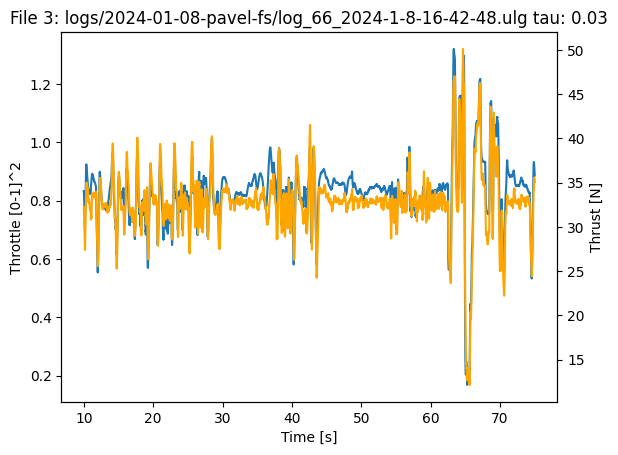

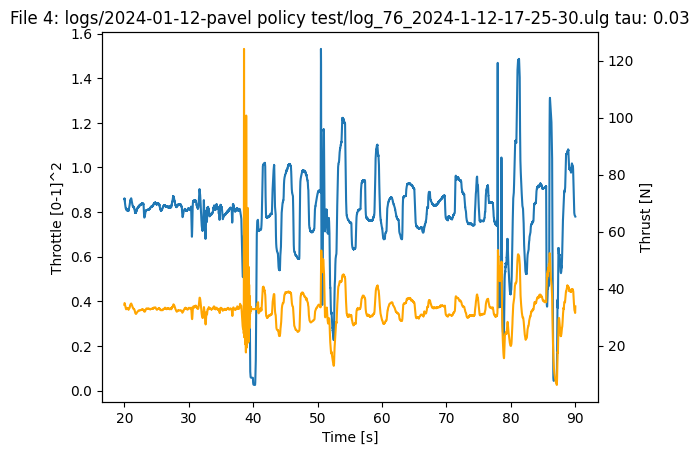

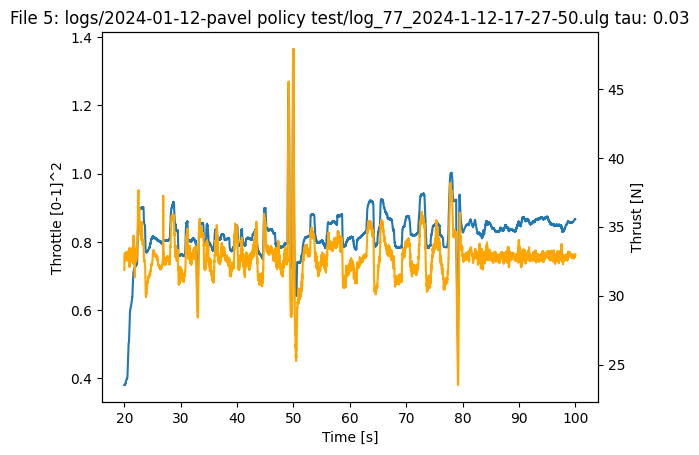

In [7]:
tau_test = 0.03
dfs_tt = [throttle_thrust(df, tau_test, model, output_topic) for df in dfs]
for i, (file, df) in enumerate(zip(ulog_files, dfs_tt)):
    plt.figure()
    plt.title(f"File {i}: {file} tau: {tau_test}")
    plt.plot(df["throttle"].dropna(), label="throttle")
    plt.ylabel("Throttle [0-1]^2")
    plt.xlabel("Time [s]")
    plt.twinx()
    plt.plot(df["thrust"].dropna(), label="acceleration", color="orange")
    plt.ylabel("Thrust [N]")
    plt.show()

100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


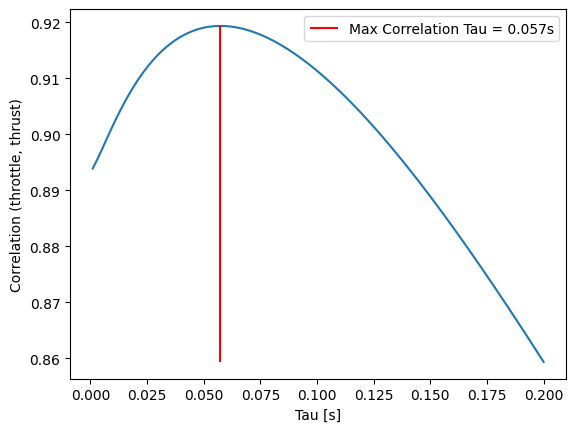

In [8]:
# throttle_estimation_files = list(range(len(ulog_files)))
if model_name in ["x500", "race6"]:
    throttle_estimation_files = [0]
elif model_name == "fs":
    throttle_estimation_files = [0, 4, 5]
tau_correlations = find_tau([dfs[i] for i in throttle_estimation_files], model, output_topic)
tau_argmax = tau_correlations[:, 1].argmax()
tau = tau_correlations[tau_argmax, 0]
plt.plot(tau_correlations[:, 0], tau_correlations[:, 1])
plt.vlines(tau, tau_correlations[:, 1].min(), tau_correlations[:, 1].max(), color="red", label=f"Max Correlation Tau = {tau:.3f}s")
plt.xlabel("Tau [s]")
plt.ylabel("Correlation (throttle, thrust)")
plt.legend()
plt.savefig(f"figures/tau_correlation_{model_name}.pdf")
plt.show()

In [9]:
dfs_tt = [throttle_thrust(df, tau, model, output_topic) for df in [dfs[i] for i in throttle_estimation_files]]

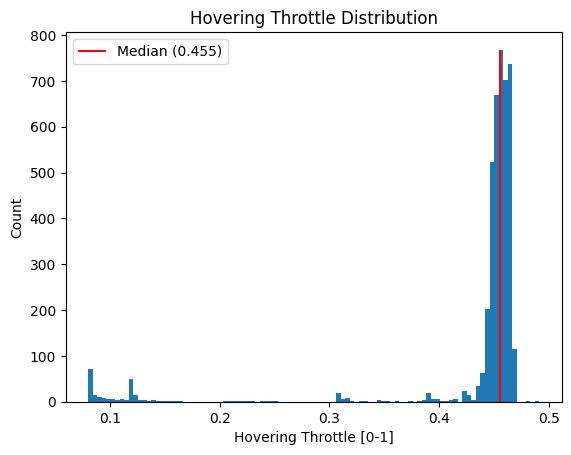

Hovering throttle: 0.45544874062357416 (per motor)


<Figure size 640x480 with 0 Axes>

In [10]:
percentile = 0.05

df_tt = pd.concat(dfs_tt)
df_sysid = df_tt[["thrust", "throttle"]].dropna()
thrust = df_sysid["thrust"]
throttle = df_sysid["throttle"]

acceleration = thrust / model.mass
real_acceleration = (acceleration - model.gravity).abs()
real_acceleration_percentile = real_acceleration.quantile(percentile)
hovering_throttles = (throttle[real_acceleration < real_acceleration_percentile]/4) ** 0.5
hovering_throttle = hovering_throttles.median()
plt.title("Hovering Throttle Distribution")
counts, bin_edges, patches = plt.hist(hovering_throttles, bins=100)
plt.vlines(hovering_throttle, 0, max(counts), color="red", label=f"Median ({hovering_throttle:.3f})")
plt.xlabel("Hovering Throttle [0-1]")
plt.ylabel("Count")
plt.legend()
plt.show()
plt.savefig(f"figures/hovering_throttle_{model_name}.pdf")
print(f"Hovering throttle: {hovering_throttle} (per motor)")

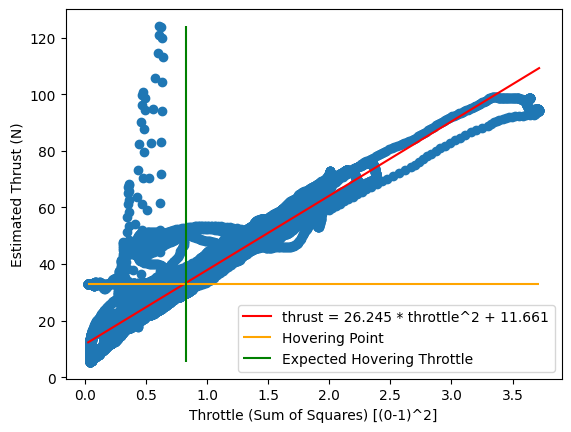

In [11]:

correlation, (slope, intercept) = fit_tau(dfs_tt, tau, model, output_topic)
plot_thrust_curve(df_tt, model, output_topic, tau, slope, intercept, hovering_throttle, filename=f"figures/thrust_curve_{model_name}.pdf")

Correlation: 0.5891739413406992


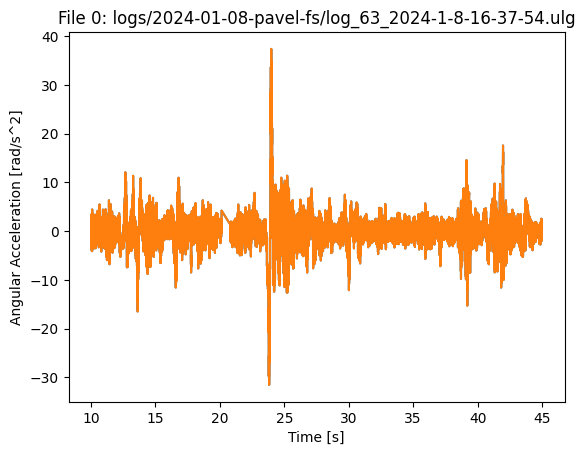

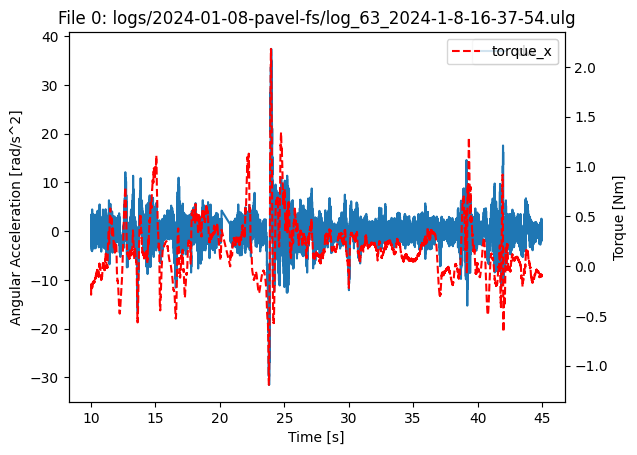

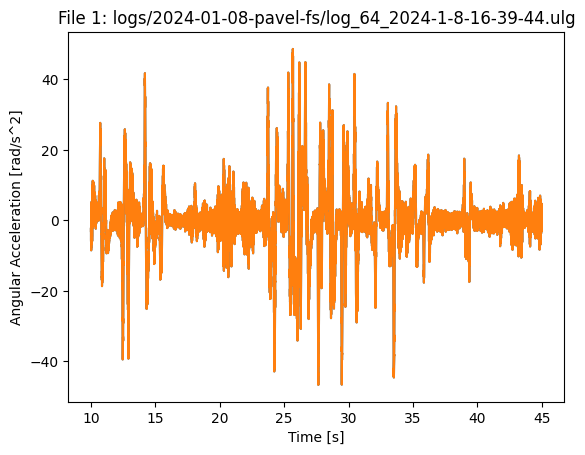

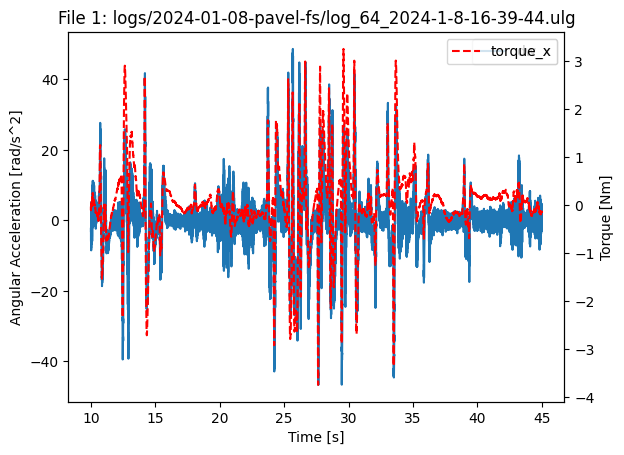

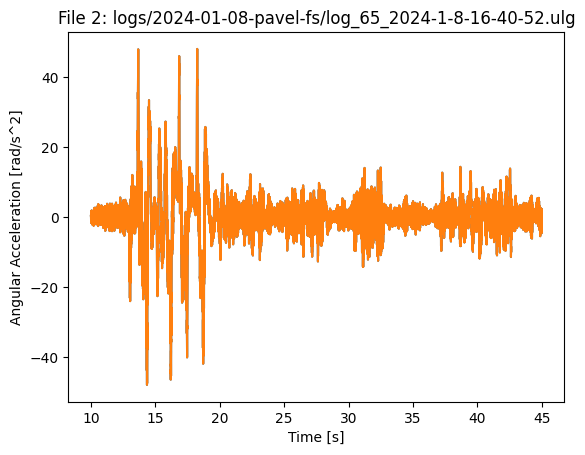

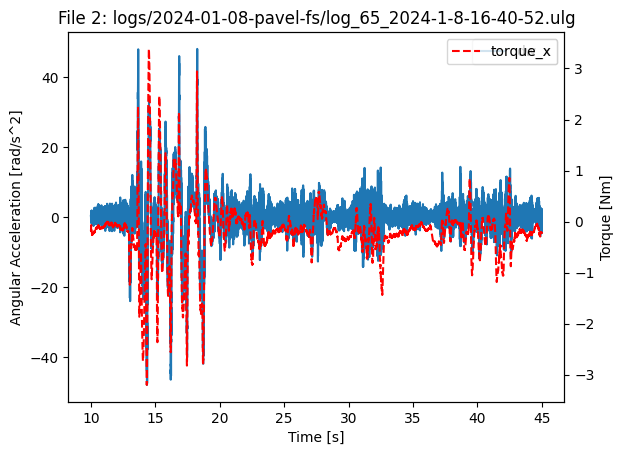

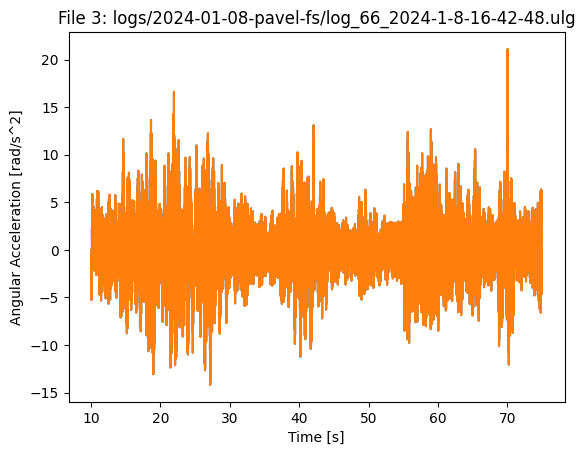

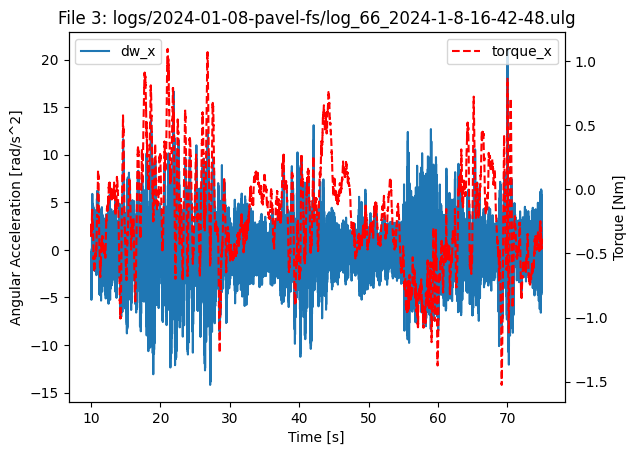

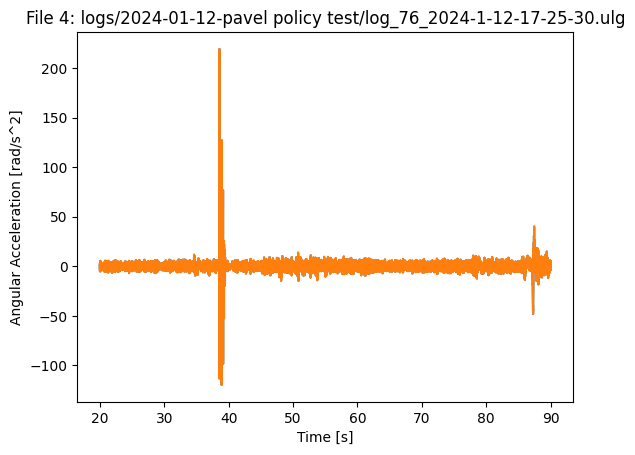

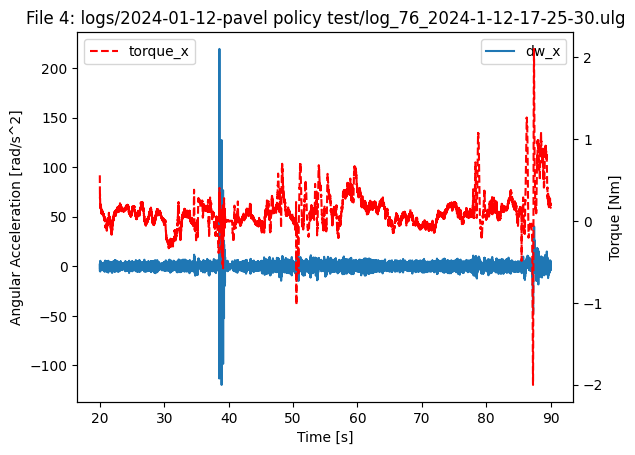

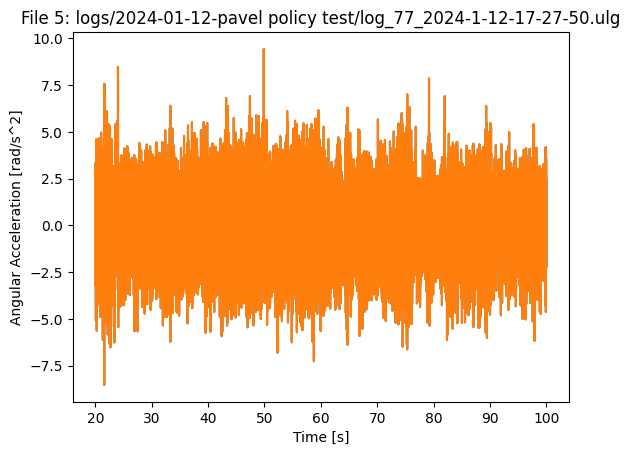

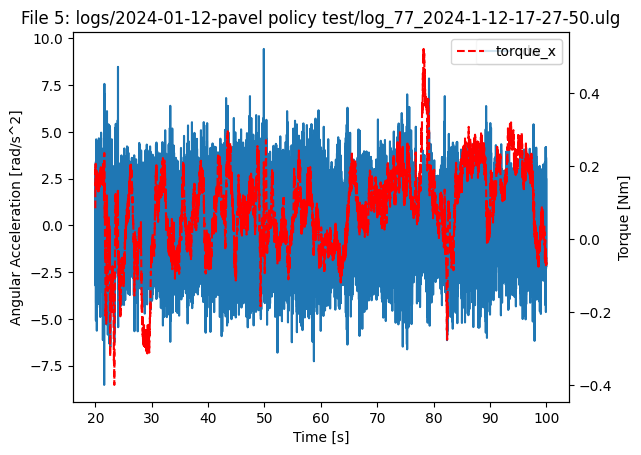

In [12]:
dfs_tac = [torque_angular_acceleration(df, model, output_topic, tau, slope, intercept) for df in dfs]
df_tac = pd.concat(dfs_tac)
tac_correlation = df_tac["torque_x"].corr(df_tac["dw_x"])
print(f"Correlation: {tac_correlation}")
for i, (file, df_tt_tac) in enumerate(zip(ulog_files, dfs_tac)):

    plt.figure()
    plt.title(f"File {i}: {file}")
    plt.plot(df_tt_tac["vehicle_angular_velocity_xyz_derivative[0]"].dropna(), label="vehicle_angular_velocity_xyz_derivative[0]")
    plt.plot(df_tt_tac["dw_x"].dropna(), label="dw_x")
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Acceleration [rad/s^2]")
    plt.show()

    plt.figure()
    plt.title(f"File {i}: {file}")
    plt.plot(df_tt_tac["dw_x"].dropna(), label="dw_x")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Acceleration [rad/s^2]")
    plt.twinx()
    plt.plot(df_tt_tac["torque_x"].dropna(), label="torque_x", color="red", linestyle="--")
    plt.ylabel("Torque [Nm]")
    plt.legend()
    plt.show()

Correlation x 0.7820732168051272
Correlation y 0.780512646883371


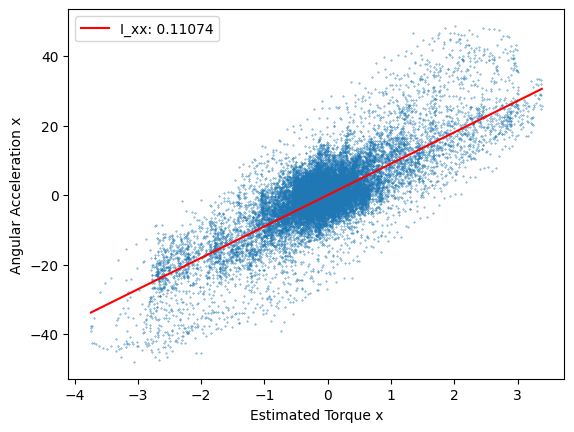

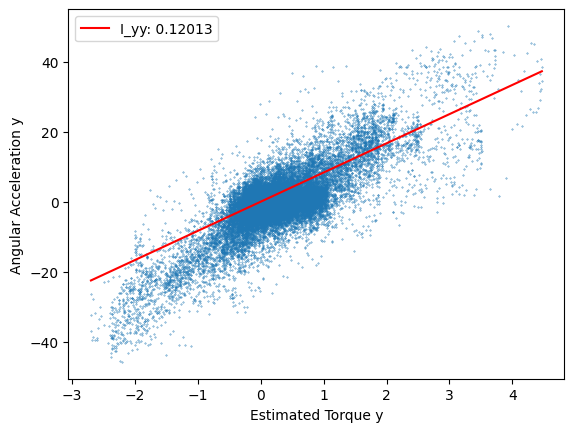

In [13]:
# angular_acceleration_files = list(range(len(ulog_files)))
if model_name == "x500":
    inertia_estimation_files = [1] 
elif model_name == "race6":
    inertia_estimation_files = [2]
elif model_name == "fs":
    inertia_estimation_files = [1, 2]
I_x, I_y = fit_inertia([dfs[i] for i in inertia_estimation_files], model, output_topic, tau, slope, intercept)
plot_torque_angular_acceleration_curve([dfs[i] for i in inertia_estimation_files], model, output_topic, tau, slope, intercept, filename=f"figures/angular_acceleration_curve_{model_name}")

### Load Inertias from Other Quadrotors to estimate Izz

In [14]:
df_inertias = pd.read_csv("quadrotor_inertias.csv")

In [15]:
df_inertias["i_zz_ratio_mean"] = df_inertias["i_zz"] * 2 / (df_inertias["i_xx"] + df_inertias["i_yy"])
df_inertias["i_zz_ratio_max"] = df_inertias["i_zz"] / (df_inertias[["i_xx", "i_yy"]].max(axis=1))
df_inertias

,model,source,Shape,mass,i_xx,i_yy,i_zz,i_zz_ratio_mean,i_zz_ratio_max
0,x500 (px4 gazebo),https://github.com/PX4/PX4-gazebo-models/blob/...,symmetric,2.000,0.022000,0.022000,0.040000,1.818182,1.818182
1,Leshikar et al,Asymmetric Quadrotor Modeling and State-Space ...,asymmetric,2.500,54.700000,15.600000,57.200000,1.627312,1.045704
2,Kaputa et al,http://www.ravvenlabs.com/uploads/1/1/8/4/1184...,symmetric,0.250,0.000427,0.000609,0.001500,2.895753,2.463054
3,Flightmare,https://github.com/uzh-rpg/flightmare/blob/mas...,symmetric,0.730,0.007911,0.007911,0.012307,1.555554,1.555554
4,Crazyflie,Learning to fly in Seconds,symmetric,0.027,0.000004,0.000004,0.000006,1.550649,1.550649
5,Iris,https://github.com/PX4/PX4-SITL_gazebo-classic...,asymmetric,1.500,0.029125,0.029125,0.055225,1.896137,1.896137
6,px4vision,https://github.com/PX4/PX4-SITL_gazebo-classic...,symmetric,1.500,0.029125,0.029125,0.055225,1.896137,1.896137
7,x-wing,https://dl.acm.org/doi/10.1145/3306346.3322940,symmetric,1.532,0.184000,0.191000,0.336000,1.792000,1.759162


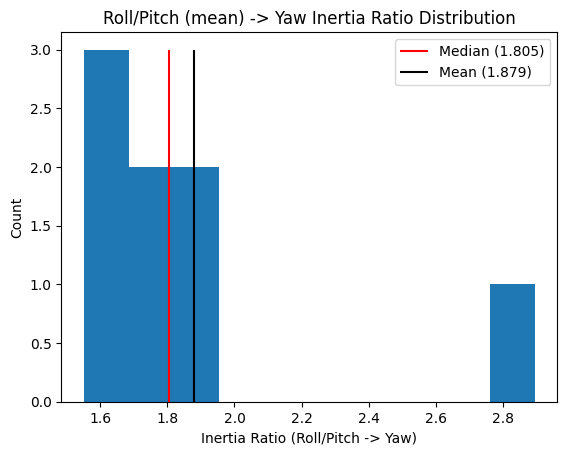

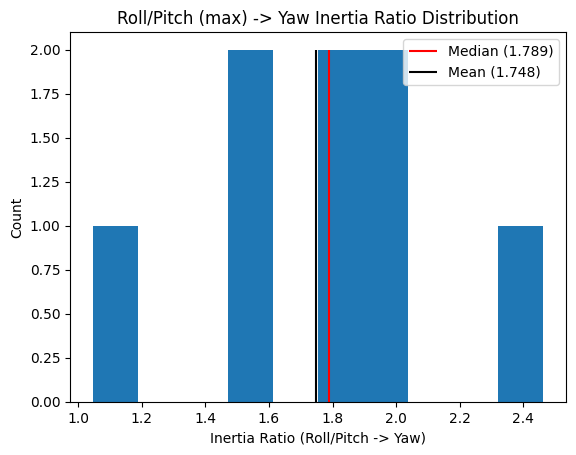

In [16]:
df_inertias["model"]

In [ ]:
# df_inertias_sane = df_inertias[df_inertias["i_xx"] < 0.15]
df_inertias_sane = df_inertias
plt.scatter((df_inertias_sane["i_xx"] + df_inertias_sane["i_yy"])/2, df_inertias_sane["i_zz"], label="Data")
# plt.scatter(np.maximum(df_inertias_sane["i_xx"], df_inertias_sane["i_yy"]), df_inertias_sane["i_zz"], label="Max")
inertias_input = np.linspace(df_inertias_sane[["i_xx", "i_yy"]].min().min(), df_inertias_sane[["i_xx", "i_yy"]].max().max(), 100)
plt.plot(inertias_input, df_inertias_sane["i_zz_ratio_mean"].mean() * inertias_input, label=f"Predicted (slope: {df_inertias_sane['i_zz_ratio_mean'].mean():.3f})")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\\frac{I_{xx} + I_{yy}}{2} \quad [kg*m^2]$")
plt.ylabel(r"$I_{zz} \quad [kg*m^2]$")
plt.legend()
plt.savefig(f"figures/inertia_ratio.pdf")

In [ ]:
print(df_inertias[[col for col in df_inertias.keys() if col not in ["source", "i_zz_ratio_max", "Shape"]]].to_latex())

In [ ]:
plt.figure()
counts, bin_edges, patches = plt.hist(df_inertias["i_zz_ratio_mean"], bins=10)
plt.title("Roll/Pitch (mean) -> Yaw Inertia Ratio Distribution")
plt.vlines(df_inertias["i_zz_ratio_mean"].median(), 0, max(counts), color="red", label=f"Median ({df_inertias['i_zz_ratio_mean'].median():.3f})")
plt.vlines(df_inertias["i_zz_ratio_mean"].mean(), 0, max(counts), color="black", label=f"Mean ({df_inertias['i_zz_ratio_mean'].mean():.3f})")
plt.legend()
plt.xlabel("Inertia Ratio (Roll/Pitch -> Yaw)")
plt.ylabel("Count")
plt.show()
plt.figure()
plt.title("Roll/Pitch (max) -> Yaw Inertia Ratio Distribution")
counts, bin_edges, patches = plt.hist(df_inertias["i_zz_ratio_max"], bins=10)
plt.vlines(df_inertias["i_zz_ratio_max"].median(), 0, max(counts), color="red", label=f"Median ({df_inertias['i_zz_ratio_max'].median():.3f})")
plt.vlines(df_inertias["i_zz_ratio_max"].mean(), 0, max(counts), color="black", label=f"Mean ({df_inertias['i_zz_ratio_max'].mean():.3f})")
plt.xlabel("Inertia Ratio (Roll/Pitch -> Yaw)")
plt.ylabel("Count")
plt.legend()
plt.show()

In [17]:
std_mean = df_inertias["i_zz_ratio_mean"].std()
std_max = df_inertias["i_zz_ratio_max"].std()
print(f"Predictive standard deviation: mean: {std_mean:.3f} max: {std_max:.3f}")
use_mean = std_mean < std_max
if use_mean:
    inertia_ratio = df_inertias["i_zz_ratio_mean"].median()
    print(f"Using mean: {inertia_ratio:.3f}")
else:
    inertia_ratio = df_inertias["i_zz_ratio_max"].median()
    print(f"Using max, inertia ratio: {inertia_ratio:.3f}")
I_z = (I_x + I_y)/2 * inertia_ratio if use_mean else max(I_x, I_y) * inertia_ratio
print(f"Estimated I_z: {I_z:.3f}")
I = np.diag([I_x, I_y, I_z])
I

Predictive standard deviation: mean: 0.434 max: 0.402
Using max, inertia ratio: 1.789
Estimated I_z: 0.215


array([[0.11073693, 0.        , 0.        ],
       [0.        , 0.12012518, 0.        ],
       [0.        , 0.        , 0.21486455]])

In [18]:
if model_name == "x500":
    z_inertia_estimation_files = [1]
elif model_name == "race6":
    z_inertia_estimation_files = [2]
elif model_name == "fs":
    z_inertia_estimation_files = [3]
else: 
    raise ValueError("Unknown model name")
dfs_tac = [torque_angular_acceleration(df, model, output_topic, tau, slope, intercept) for df in [dfs[i] for i in z_inertia_estimation_files]]

In [19]:
df_orig = dfs_tac[0]
selected_cols = [*[f"{output_topic}_control[{i}]" for i in range(4)], *[f"torque_{i}" for i in ["x", "y", "z"]], *[f"dw_{i}" for i in ["x", "y", "z"]]]
df = df_orig[selected_cols].dropna(how="all").copy()
old_index = df.index
df.index = pd.to_datetime(df.index, unit="s")
df = df.interpolate(method="time")
df.index = old_index
df = df.dropna()
throttle2thrust = lambda throttle: throttle ** 2 * slope + intercept / 4
throttle2draginput = lambda i, throttle: throttle2thrust(throttle) * model.rotor_torque_directions[i]
for motor_i in range(4):
    for axis_i, axis in enumerate(["x", "y", "z"]):
        df[f"torque_drag_input[{motor_i}]_{axis}"] = df[f"{output_topic}_control[{motor_i}]"].ewm(halflife=f"{tau*np.log(2)} s", times=pd.to_datetime(df.index, unit="s")).mean().map(lambda throttle: throttle2draginput(motor_i, throttle)[axis_i])

In [20]:
thrust_angular_acceleration_z = df["torque_z"] / I_z
residual_angular_acceleration_z = (-df["dw_z"]) - thrust_angular_acceleration_z # convert dw_z from FRD to FLU
residual_torque_z = residual_angular_acceleration_z * I_z

In [21]:
drag_input_z = sum([df[f"torque_drag_input[{motor_i}]_z"] for motor_i in range(4)])

kd_model = LinearRegression()
print(f"Correlation {drag_input_z.corr(residual_torque_z)}")
kd_model.fit(drag_input_z.values.reshape(-1, 1), residual_torque_z.values)
Kd, Kd_intercept = (kd_model.coef_[0], kd_model.intercept_)


Correlation 0.2591652356901038


In [22]:
import ipywidgets as widgets
# %matplotlib widget
x = np.linspace(drag_input_z.min(), drag_input_z.max(), 100)
y = x * Kd + Kd_intercept
fig, ax = plt.subplots()
plt.scatter(drag_input_z, residual_torque_z, s=0.1)
line, = plt.plot(x, y, color="red", label=f"Kd = {Kd:.3f}")
plt.ylabel("Residual Torque [Nm]")
plt.xlabel("Drag Input [N]")
plt.title("Thrust -> Torque (Drag) Curve")
plt.legend()


slider = widgets.FloatSlider(
    value=Kd,
    min=0,
    max=1,
    step=0.01,
    description='Kd'
)

display(slider)

def update_plot(change):
    global Kd
    Kd = change.new
    line.set_ydata(x * change.new + Kd_intercept)
    line.set_label(f"Kd = {change.new:.3f}")
    fig.canvas.draw_idle()
    ax.legend()

slider.observe(update_plot, names='value')

ModuleNotFoundError: No module named 'ipywidgets'

In [ ]:
print(f"rotor_positions: \n{model.rotor_positions}")
print(f"rotor_thrust_directions: \n{model.rotor_thrust_directions}")
print(f"rotor_torque_directions: \n{model.rotor_torque_directions}")
print(f"mass: {model.mass:.5f}")
print(f"tau: {tau:.5f}")
print(f"Kf[0]: {intercept/4:.5f}")
print(f"Kf[1]: {0:.5f}")
print(f"Kf[2]: {slope:.5f}")
print(f"Kd: {Kd:.5f}")
print(f"Ixx: {I_x:.5f}")
print(f"Iyy: {I_y:.5f}")
print(f"Izz: {I_z:.5f}")
print(f"hovering_throttle: {hovering_throttle:.5f}")

In [ ]:
nan_cols = dfs[0].interpolate().isna().sum()
for c in nan_cols[nan_cols > 0].items():
    print(c)


# Step 0: Load the data

In [ ]:
wanted_columns = [
    *[f"vehicle_attitude_q[{i}]" for i in range(4)],
    *[f"vehicle_acceleration_xyz[{i}]" for i in range(3)],
    *[f"vehicle_angular_velocity_xyz[{i}]" for i in range(3)],
    *[f"vehicle_angular_velocity_xyz_derivative[{i}]" for i in range(3)],
    *[f"{output_topic}_control[{i}]" for i in range(4)],
]

# flights => timeseries (timestamp + single value) => split up into separate time-series based on gaps

flights = [
    {
        "name": name,
        "data": {
            name: {
                "timestamps": np.array(c.index),
                "values": np.array(c)
            } for name, c in [(wc, df[wc].dropna()) for wc in wanted_columns]
        }
    } for name, df in zip(ulog_files, dfs)
]

# Step 1: Plot the flights

In [ ]:
def plot_flights(flights):
    for flight in flights:
        plt.figure()
        plt.title(flight["name"])
        for motor_i, motor in enumerate([f"{output_topic}_control[{i}]" for i in range(4)]):
            plt.plot(flight["data"][motor]["timestamps"], flight["data"][motor]["values"], label=f"motor {motor_i}")
        plt.show()
plot_flights(flights)

In [ ]:
# timeframes_thrust = [
#     {
#         "flight": 1,
#         "start": 
#     }
# ]
# timeframes_inertia = [

# ]

flights_thrust = [flights[i] for i in [0, 4, 5]]
flights_inertia = [flights[i] for i in [1, 2]]

# Step 2: Select Flights and Time Slices

# Step 3: Detect gaps and interpolate data

In [ ]:
def slice_gaps_and_interpolate(flights):
    flights_output = []
    for flight in flights:
        lowest_frequency = None
        lowest_frequency_name = None
        highest_frequency = None
        highest_frequency_name = None
        for name, data in flight["data"].items():
            diff = np.diff(data["timestamps"])
            frequency = 1/np.median(diff)
            if lowest_frequency is None or frequency < lowest_frequency:
                lowest_frequency = frequency
                lowest_frequency_name = name
            if highest_frequency is None or frequency > highest_frequency:
                highest_frequency = frequency
                highest_frequency_name = name
            # print(f"{name}: {1/np.median(diff)}")

        interval_threshold = 3 * 1/lowest_frequency
        print(f"Lowest frequency: {lowest_frequency} for {lowest_frequency_name}")
        print(f"Highest frequency: {highest_frequency} for {highest_frequency_name}")

        earliest_timestamp_all = max([data["timestamps"][0] for name, data in flight["data"].items()])
        latest_timestamp_all = min([data["timestamps"][-1] for name, data in flight["data"].items()])
        print(f"Earliest timestamp_all: {earliest_timestamp_all}")
        print(f"Latest timestamp_all: {latest_timestamp_all}")
        master_timestamps_full = flight["data"][highest_frequency_name]["timestamps"]
        master_timestamps = master_timestamps_full[(master_timestamps_full > earliest_timestamp_all) & (master_timestamps_full < latest_timestamp_all)]
        earliest_timestamp = master_timestamps[0]
        latest_timestamp = master_timestamps[-1]
        print(f"Cutting {(100 * (1 - len(master_timestamps) / len(master_timestamps_full))):.2f}% of the data to synchronize the timestamp start and end")

        total_time = latest_timestamp - earliest_timestamp

        gaps = []
        for name, data in flight["data"].items():
            current_timestamps_full = data["timestamps"]
            current_timestamps = current_timestamps_full[(current_timestamps_full > earliest_timestamp) & (current_timestamps_full < latest_timestamp)]
            current_timestamps_augmented = np.concatenate([[earliest_timestamp], current_timestamps, [latest_timestamp]])
            diff = np.diff(current_timestamps_augmented)
            current_gaps = np.where(diff > interval_threshold)[0]
            for gap in current_gaps:
                gap_start = data["timestamps"][gap]
                gap_end = data["timestamps"][gap+1]
                gaps.append((gap_start, gap_end))
        gaps_sorted = sorted(gaps, key=lambda x: x[0])


        current_gap_start = None
        current_gap_end = None
        combined_gaps = []

        for i, (gap_start, gap_end) in enumerate(gaps_sorted):
            if current_gap_start is None:
                current_gap_start = gap_start
            
            if current_gap_end is None:
                current_gap_end = gap_end
            
            if gap_end > current_gap_end:
                current_gap_end = gap_end
            
            if i < len(gaps_sorted) - 1:
                next_gap_start, next_gap_end = gaps_sorted[i+1]
                if next_gap_start - current_gap_end > interval_threshold:
                    print(f"Gap: {current_gap_start} - {current_gap_end}")
                    combined_gaps.append((current_gap_start, current_gap_end))
                    current_gap_start = None
                    current_gap_end = None
            else:
                print(f"Gap start {gap_start} - {gap_end}")
                print(f"Final Gap: {current_gap_start} - {current_gap_end}")
                combined_gaps.append((current_gap_start, current_gap_end))
        print(f"Number of gaps: {len(combined_gaps)}")

        total_gap_time = sum([gap_end - gap_start for gap_start, gap_end in combined_gaps])
        assert total_gap_time < 0.1 * total_time, f"Total gap time: {total_gap_time:.2f}s"

        subflights = []
        current_segment_start_timestamp = earliest_timestamp
        for gap_start, gap_end in [*combined_gaps, (latest_timestamp, latest_timestamp)]:
            segment_time = gap_start - current_segment_start_timestamp
            if segment_time > 0.01 * total_time:
                current_segment_timestamps = master_timestamps[(master_timestamps > current_segment_start_timestamp) & (master_timestamps < gap_start)]
                sub_flight = {
                    name: {
                        "timestamps": current_segment_timestamps,
                        "values": np.interp(current_segment_timestamps, data["timestamps"], data["values"])
                    } for name, data in flight["data"].items()
                }
                subflights.append(sub_flight)
            else:
                print(f"Skipping segment of length {segment_time:.2f}s")
            current_segment_start_timestamp = gap_end
        print(f"Number of subflights: {len(subflights)}")
        print(subflights[0].keys())


        for subflight in subflights:
            plt.figure()
            plt.title(flight["name"])
            for i, key in enumerate([f"actuator_motors_mux_control[{i}]" for i in range(4)]):
                ts = subflight[key]
                plt.plot(ts["timestamps"], ts["values"], label=f"motor {i}")
            plt.legend()
        
        for subflight_i, subflight in enumerate(subflights):
            flights_output.append({
                "name": flight["name"] + f"_{subflight_i}",
                "timestamps": subflight[highest_frequency_name]["timestamps"],
                "data": subflight
            })
    return flights_output

In [ ]:
sliced_and_interpolated_flights_thrust = slice_gaps_and_interpolate(flights_thrust)
sliced_and_interpolated_flights_inertia = slice_gaps_and_interpolate(flights_inertia)

# Step 4: Apply stateful transformation (filter motor data)

In [ ]:

def filter_ema(timestamps, rpm_setpoints, T_m):
    rpms_filtered = []
    rpm = None
    previous_t = None
    for t, rpm_setpoint in zip(timestamps, rpm_setpoints):
        if rpm is None:
            rpm = rpm_setpoint
        else:
            delta_t = t - previous_t
            alpha = np.exp(-delta_t / T_m)
            rpm = alpha*rpm + (1-alpha) * rpm_setpoint
        rpms_filtered.append(rpm)
        previous_t = t
    return np.array(rpms_filtered)

def combine(flights, T_m, frd=True, T_omega=0.05, thrust_curves=None):
    assert thrust_curves is None or len(thrust_curves) == 4
    from scipy.spatial.transform import Rotation as R
    def FRD2FLU(x):
        return np.array([x[0], -x[1], -x[2]])

    def FRD2FLU_quat(q):
        return R.from_quat([q[1], -q[2], -q[3], q[0]])
    from copy import deepcopy
    flights = deepcopy(flights)
    for flight in flights:
        timestamps = flight["timestamps"]
        # num_steps = len(timestamps)
        rpm_setpoints = np.array([flight["data"][f"{output_topic}_control[{i}]"]["values"] for i in range(4)]).T
        flight["rpm_setpoints"] = rpm_setpoints
        flight["rpms"] = filter_ema(timestamps, rpm_setpoints, T_m)
        acceleration = np.array([flight["data"][f"vehicle_acceleration_xyz[{i}]"]["values"] for i in range(3)]).T
        flight["acceleration"] = np.array(list(map(FRD2FLU, acceleration))) if frd else acceleration
        omega_original_frame = np.array([flight["data"][f"vehicle_angular_velocity_xyz[{i}]"]["values"] for i in range(3)]).T
        omega = np.array(list(map(FRD2FLU, omega_original_frame))) if frd else omega_original_frame
        flight["omega"] = omega
        domega_original_frame = np.array([flight["data"][f"vehicle_angular_velocity_xyz_derivative[{i}]"]["values"] for i in range(3)]).T
        domega = np.array(list(map(FRD2FLU, domega_original_frame))) if frd else domega_original_frame
        flight["domega"] = domega
        flight["domega_smooth"] = filter_ema(timestamps, domega, T_omega)
        omega_fd = (omega[1:] - omega[:-1]) / (timestamps[1:] - timestamps[:-1]).reshape(-1, 1)
        flight["domega_fd"] = np.concatenate([omega_fd, [omega_fd[-1]]])
        flight["domega_gradient"] = np.gradient(omega, timestamps, axis=0)
        if thrust_curves is not None:
            def apply_thrust_curves(rpms, thrust_curves):
                thrusts = []
                for thrust_curve_motor, rpm in zip(thrust_curves, rpms):
                    acc = 0
                    for exponent, coeff in zip(range(3), thrust_curve_motor):
                        acc += rpm**exponent * coeff
                    thrusts.append(acc)
                return np.array(thrusts)
            flight["thrusts"] = np.array([apply_thrust_curves(rpms, thrust_curves) for rpms in flight["rpms"]])
        
    
    thrusts_combined = {}
    if thrust_curves is not None:
        thrusts_combined = {
            "thrusts": np.concatenate([flight["thrusts"] for flight in flights])
        }

    return {
        "rpm_setpoints": np.concatenate([flight["rpm_setpoints"] for flight in flights]),
        "rpms": np.concatenate([flight["rpms"] for flight in flights]),
        "acceleration": np.concatenate([flight["acceleration"] for flight in flights]),
        "omega": np.concatenate([flight["omega"] for flight in flights]),
        "domega": np.concatenate([flight["domega"] for flight in flights]),
        "domega_smooth": np.concatenate([flight["domega_smooth"] for flight in flights]),
        "domega_fd": np.concatenate([flight["domega_fd"] for flight in flights]),
        "domega_gradient": np.concatenate([flight["domega_gradient"] for flight in flights]),
        **thrusts_combined
    }, flights


In [ ]:
T_m_test = 0.05
combined_test, _ = combine(sliced_and_interpolated_flights_thrust, T_m_test)

In [ ]:
combined_test["acceleration"].shape

In [ ]:
def estimate_motor_parameters(combined, model, exponents, verbose=True):
    b = []
    A = []


    num_steps = len(combined["rpms"])
    for step_i in range(num_steps):
        acceleration = combined["acceleration"][step_i]
        b.append(model["mass"] * acceleration)
        current_A = []
        rpm = combined["rpms"][step_i]
        for motor_i in range(4):
            for exponent in exponents:
                current_A.append(model["rotor_thrust_directions"][motor_i] * rpm[motor_i] ** exponent)
        A.append(np.array(current_A).T)

    A = np.array(A).reshape(-1, 4 * len(exponents))
    b = np.array(b).reshape(-1)
    if verbose:
        print(f"A shape: {A.shape}")
        print(f"b shape: {b.shape}")
    K_f = np.linalg.lstsq(A, b, rcond=None)[0].reshape(-1, len(exponents))
    rmse = np.sqrt(np.mean((A @ K_f.reshape(-1) - b) ** 2))
    K_f_full = np.array([[K_f[motor_i][exponents.index(i)] if i in exponents else 0 for i in range(3)] for motor_i in range(4)])
    return K_f_full, rmse

In [ ]:

# we want to do something
# we have selected flights to use for this
# cut out the relevant timeframe
# we slice the flights based on gaps and interpolate
# we then preprocess the data with time correlation (depends on the motor model) => makes the data iid
# we use the iid data to estimate parameters


rotor_x_displacement = 0.4179/2
rotor_y_displacement = 0.481332/2
# model is in FLU frame
model = {
    "gravity": 9.81,
    "mass": 2.3 + 1.05,
    "rotor_positions": np.array([
        [ rotor_x_displacement, -rotor_y_displacement, 0],
        [-rotor_x_displacement,  rotor_y_displacement, 0],
        [ rotor_x_displacement,  rotor_y_displacement, 0],
        [-rotor_x_displacement, -rotor_y_displacement, 0]
    ]),
    "rotor_thrust_directions": np.array([
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]
    ]),
    "rotor_torque_directions": np.array([
        [0, 0, -1],
        [0, 0, -1],
        [0, 0,  1],
        [0, 0,  1]
    ])
}
g = np.array([0, 0, -model["gravity"]])
exponents = [0, 2]
K_f_test, rmse = estimate_motor_parameters(combined_test, model, exponents)
print(f"K_f_test: {K_f_test}")
K_f_test_mean = K_f_test.mean(axis=0)
print(f"K_f_test_mean: {K_f_test_mean}")
# rmse = motor_model_rmse(K_f_mean, combined, model, exponents)
print(f"RMSE: {rmse:.3f}")

from tqdm import tqdm
from tqdm.notebook import tqdm

T_m_candidates = np.linspace(0.001, 0.3, 20)
results = [(T_m, *estimate_motor_parameters(combine(sliced_and_interpolated_flights_thrust, T_m)[0], model, exponents, verbose=False)) for T_m in tqdm(T_m_candidates)]
T_m, K_fs, rmses = zip(*results)

In [ ]:
T_m = T_m_candidates[np.argmin(rmses)]
K_f = K_fs[np.argmin(rmses)]
K_f_mean = K_f.mean(axis=0)
plt.figure()
plt.plot(T_m_candidates, rmses, label=f"T_m = {T_m}")
plt.legend()
plt.show()

thrust_curves = np.array([K_f_mean for _ in range(4)])

combined_thrust, flights_thrust_processed = combine(sliced_and_interpolated_flights_thrust, T_m, thrust_curves=thrust_curves)
combined_inertia, flights_inertia_processed = combine(sliced_and_interpolated_flights_inertia, T_m, thrust_curves=thrust_curves)

In [ ]:
combine(sliced_and_interpolated_flights_thrust, T_m)

use_mean_kf = True
A = []
b = []

t = []

num_steps = len(combined_inertia["rpms"])
for step_i in tqdm(range(num_steps)):
    wx, wy, wz = np.zeros(3) #combined["omega"][step_i]
    dwx, dwy, dwz = combined_inertia["domega"][step_i]
    rpm = combined_thrust["rpms"][step_i]
    thrusts = [sum([(K_f_mean if use_mean_kf else K_f[motor_i])[exponent_i] * rpm[motor_i] ** exponent for exponent_i, exponent in enumerate(exponents)]) for motor_i in range(4)]
    t.append(thrusts)
    current_b = np.array([np.cross(model["rotor_positions"][motor_i], model["rotor_thrust_directions"][motor_i]) * thrusts[motor_i] for motor_i in range(4)]).sum(axis=0)
    b.append(current_b[:2])
    # current_A_J = np.array([
    #     [dwx, -wy*wz, wz*wy],
    #     [wx*wz, dwy, -wz*wx],
    #     [-wx*wy, wy*wx, dwz]
    # ])
    current_A_J = np.array([
        [dwx, 0],
        [0, dwy],
    ])
    # current_A_Kd = np.array([-model["rotor_torque_directions"][motor_i] * thrusts[motor_i] for motor_i in range(4)]).T
    # current_A = np.concatenate([current_A_J, current_A_Kd], axis=1)
    A.append(current_A_J)

In [ ]:
use_mean_kf = True
A_full = []
A_2x2 = []
A_z_full = []
A_z = []
b_full = []
b_2 = []
b_z = []

t = []
torques = []
drag_torques = []

num_steps = len(combined_inertia["rpms"])
for step_i in tqdm(range(num_steps)):
    wx, wy, wz = np.zeros(3) #combined[\"omega\"][step_i]\n",
    dwx, dwy, dwz = combined_inertia["domega_fd"][step_i]
    rpm = combined_inertia["rpms"][step_i]
    # thrusts = [sum([(K_f_mean if use_mean_kf else K_f[motor_i])[exponent_i] * rpm[motor_i] ** exponent for exponent_i, exponent in enumerate(exponents)]) for motor_i in range(4)]
    thrusts = combined_inertia["thrusts"][step_i]
    t.append(thrusts)
    current_b = np.array([np.cross(model["rotor_positions"][motor_i], model["rotor_thrust_directions"][motor_i]) * thrusts[motor_i] for motor_i in range(4)]).sum(axis=0)
    torques.append(current_b)
    b_full.append(current_b[:2])
    b_2.append(current_b[:2])
    b_z.append(current_b[2])
    current_A_J = np.array([
        [dwx, -wy*wz, wz*wy],
        [wx*wz, dwy, -wz*wx],
        [-wx*wy, wy*wx, dwz]
    ])
    current_A_Kd = np.array([-model["rotor_torque_directions"][motor_i] * thrusts[motor_i] for motor_i in range(4)]).T #.sum(axis=1).reshape(3, 1)
    drag_torques.append(current_A_Kd)
    current_A = np.concatenate([current_A_J, current_A_Kd], axis=1)
    A_full.append(current_A)
    current_A_J_2x2 = np.array([
        [dwx, 0],
        [0, dwy],
    ])
    A_2x2.append(current_A_J_2x2)
    A_z_full.append(np.array([dwz, *current_A_Kd[2, :]]))
    A_z.append(np.array([dwz, *current_A_Kd.sum(axis=1)]))



In [ ]:
print(f"A shape: {np.array(A_full).shape}")

A_full = np.array(A_full).reshape(-1, A_full[0].shape[-1])
b_full = np.array(b_full).reshape(-1)
A_2x2 = np.array(A_2x2).reshape(-1, A_2x2[0].shape[-1])
b_2 = np.array(b_2).reshape(-1)

t = np.array(t)
torques = np.array(torques)
drag_torques = np.array(drag_torques)
drag_torques.shape

In [ ]:
np.unique(combined_inertia["thrusts"])

In [ ]:
plt.scatter(combined_thrust["thrusts"].sum(axis=1), combined_thrust["acceleration"][:, 2]*model["mass"], s=0.05) 
plt.plot([0, 100], [0, 100], color="red")
K_f_mean

In [ ]:
start_index = np.argmax(flights_inertia_processed[0]["timestamps"] > 25)
end_index = np.argmax(flights_inertia_processed[0]["timestamps"] > 30)

plt.plot(flights_inertia_processed[0]["timestamps"][start_index:end_index], flights_inertia_processed[0]["domega_fd"][start_index:end_index, 0])
plt.plot(flights_inertia_processed[0]["timestamps"][start_index:end_index], flights_inertia_processed[0]["domega_gradient"][start_index:end_index, 0])
plt.plot(flights_inertia_processed[0]["timestamps"][start_index:end_index], flights_inertia_processed[0]["domega"][start_index:end_index, 0])

In [ ]:
combined_inertia["domega"].shape
combined_inertia["thrusts"].shape
torques[:, 2]

In [ ]:
I = []
for axis_i, axis_name in zip([0, 1], ["x", "y"]):
    dw_full = combined_inertia["domega"][:, axis_i]
    torque_full = torques[:, axis_i]
    perc = 50
    dw_perc_lower = np.percentile(dw_full, perc)
    dw_perc_upper = np.percentile(dw_full, 100-perc)
    print(f"domega lower: {dw_perc_lower:.3f} upper: {dw_perc_upper:.3f}")
    mask = (dw_full < dw_perc_lower) | (dw_full > dw_perc_upper)
    torques_perc_lower = np.percentile(torque_full, perc)
    torques_perc_upper = np.percentile(torque_full, 100-perc)
    # mask &= (torque_full < torques_perc_lower) | (torque_full > torques_perc_upper)
    print(f"masking rate: {1-mask.mean():.3f}")
    dw = dw_full[mask]
    torque = torque_full[mask]

    I_axis = 1/(dw**2).sum() * np.inner(dw, torque)
    print(f"I_{axis_name}{axis_name}: {I_axis:.3f}")
    plt.figure()
    plt.title(f"Axis: {axis_name}")
    if perc < 50:
        plt.scatter(torque_full, dw_full, s=0.1)
    plt.scatter(torque, dw, s=0.1)
    torques_in = np.linspace(torque_full.min(), torque_full.max(), 100)
    plt.plot(torques_in, torques_in / (I_axis), color="red")
    plt.savefig(f"figures/inertia_{axis_name}.pdf")
    plt.show()
    I.append(I_axis)

In [ ]:
dwz = combined_inertia["domega"][:, 2]
I_xx, I_yy = I[:2]
I_zz = (I_xx + I_yy)/2 * inertia_ratio if use_mean else max(I_xx, I_yy) * inertia_ratio
I = [I_xx, I_yy, I_zz]
torque_z = torques[:, 2]
I_xx, I_yy, I_zz

In [ ]:
K_ds = []
perc_candidates = [50] #np.linspace(0.1, 50, 20)
for perc in perc_candidates:
    combined_inertia["thrusts"].shape
    model["rotor_torque_directions"].shape
    thrust_torques_inputs = combined_inertia["thrusts"][:, :, np.newaxis] * model["rotor_torque_directions"]
    thrust_torque_inputs_z_full = thrust_torques_inputs[:, :, 2].sum(axis=1)
    dwz_full = combined_inertia["domega"][:, 2]

    thrust_torque_input_perc_lower = np.percentile(thrust_torque_inputs_z_full, perc)
    thrust_torque_input_perc_upper = np.percentile(thrust_torque_inputs_z_full, 100-perc)
    mask = (thrust_torque_inputs_z_full < thrust_torque_input_perc_lower) | (thrust_torque_inputs_z_full > thrust_torque_input_perc_upper)

    dwz_perc_lower = np.percentile(dwz_full, perc)
    dwz_perc_upper = np.percentile(dwz_full, 100-perc)
    mask &= (dwz_full < dwz_perc_lower) | (dwz_full > dwz_perc_upper)

    thrust_torque_inputs_z = thrust_torque_inputs_z_full[mask]
    dwz = dwz_full[mask]

    b_full = dwz_full * I_zz
    b = dwz * I_zz

    K_d = 1/(thrust_torque_inputs_z ** 2).sum() * np.inner(thrust_torque_inputs_z, b)
    K_ds.append(K_d)

    plt.figure()
    plt.scatter(thrust_torque_inputs_z_full, b_full, s=0.01)
    # plt.scatter(thrust_torque_inputs_z, dwz, s=0.1, color="red")
    plt.plot(thrust_torque_inputs_z, K_d * thrust_torque_inputs_z, color="red", label=f"$K_d$ = {K_d:.3f}")
    plt.ylabel(f"Angular Acceleration (z) $\\times$ $I_{{zz}}$ ")
    plt.xlabel(f"Normalized Torque (z)")
    plt.legend()
    plt.savefig(f"figures/K_d_{perc}.pdf")
    plt.show()


    print(f"K_d: {K_d:.3f}")

In [ ]:
plt.scatter(combined_thrust["thrusts"].sum(axis=1), combined_thrust["acceleration"][:, 2]*model["mass"])
plt.plot([0, 100], [0, 100], color="red")

In [ ]:
motor_model = lambda i, rpm: K_f[i] @ np.array([rpm ** exponent for exponent in exponents])
combine_motor_models = lambda rpms: np.array([motor_model(i, rpm) for i, rpm in enumerate(rpms)]).sum(axis=0)
plt.figure()
plt.title("Predicted vs Actual Thrust (individual motor models)")
predicted_thrust = np.array(list(map(combine_motor_models, combined_thrust["rpms"])))
actual_thrust = combined_thrust["acceleration"][:, 2] * model["mass"]
motor_models_description = "\n".join([f"motor {i}: {', '.join([f'K_f{exponent}={k:.2f}' for exponent, k in zip(exponents, K_f[i])])}" for i in range(4)])
plt.scatter(predicted_thrust, actual_thrust, s=0.1, label=motor_models_description)
min_thrust = min(predicted_thrust.min(), actual_thrust.min())
max_thrust = max(predicted_thrust.max(), actual_thrust.max())
print(f"min_thrust: {min_thrust:.3f}")
print(f"max_thrust: {max_thrust:.3f}")
plt.plot([min_thrust, max_thrust], [min_thrust, max_thrust] , color="red")
plt.legend()

In [ ]:
assert len(K_f_mean) == 2
plt.figure()
plt.title("Mean motor model")
label = f"model: {', '.join([f'K_f{exponent}={k:.2f}' for exponent, k in zip(exponents, K_f_mean)])}"
plt.scatter((combined_thrust["rpms"] ** 2).sum(axis=1), actual_thrust, s=0.1, label=label)
inputs = np.linspace(combined_thrust["rpms"].min(), (combined_thrust["rpms"]**2).sum(axis=1).max(), 100)
plt.plot(inputs, np.array([K_f_mean[0]*4 + K_f_mean[1] * ip for ip in inputs]) , color="red")
plt.legend()
plt.show()

In [ ]:
lowest_frequency = None
lowest_frequency_column = None
for c in wanted_columns:
    freq = 1/dfs[0][c].dropna().index.to_series().diff().median()
    if lowest_frequency is None or freq < lowest_frequency:
        lowest_frequency = freq
        lowest_frequency_column = c

print(f"Lowest frequency: {lowest_frequency:.3f} Hz ({lowest_frequency_column})")

time_series_separation_threshold = 3 * 1/lowest_frequency

dropout_timestamps = []
for c in wanted_columns:
    diff = dfs[0][c].dropna().index.to_series().diff()
    dropout_indices = [diff > time_series_separation_threshold].index

    for dropout in dropouts:
        start = 
        print(f"Column {c} has dropout at {dropout}")
    dropout_timestamps.extend(dropouts)



# dfs_interp = [df[wanted_columns].interpolate().dropna() for df in dfs]
dropout_timestamps

In [ ]:
diff = dfs_interp[0].index.to_series().diff()
interval = diff.median()
# plt.plot(dfs_interp[0].index.to_series().diff() > interval * 100)

diff.quantile(0.999)